In [3]:
library(rlang)
library(dplyr)
library(comprehenr)
library(bnlearn)
library(bnstruct)
library(Rgraphviz)

In [2]:
#install.packages("BiocManager")
#BiocManager::install("Rgraphviz")

## Simple test dataset

In [92]:
x1 = c(1,1,0,1,0,0,1,0,1,0)
x2 = c(0,1,0,1,0,1,1,0,1,0)
x3 = c(0,1,1,1,0,1,1,0,1,0)
df = data.frame(x1, x2, x3)

In [93]:
df

x1,x2,x3
<dbl>,<dbl>,<dbl>
1,0,0
1,1,1
0,0,1
1,1,1
0,0,0
0,1,1
1,1,1
0,0,0
1,1,1


In [6]:
# compute all possible instantiations
inst = lapply(df, n_distinct)
r    = c(inst$x1,inst$x2, inst$x3)

## K2 algorithm

### Useful functions

In [69]:
log_f_i_ = function(alpha, r_i){
    N_i_ = sum(alpha)
    return(
            sum(ifelse((r_i-1)==0, 0, sapply(1:(r_i-1),log)))- 
            sum(sapply(1:(N_i_+r_i-1),log)) + 
            sum(sapply(alpha, function(a_k){
                                    sum(ifelse(a_k==0, 0, sapply(1:(a_k),log)))
                               }
                )
            )
    )
}
log_f_ij = function(alpha, r_i){
    N_ij = rowSums(alpha)
    return(
            sum(sapply(1:length(N_ij), function(j){ 
                                            sum(ifelse((r_i-1)==0, 0, sapply(1:(r_i-1), log))) - 
                                            sum(sapply(1:(N_ij[j]+r_i-1), log)) + 
                                            sum(sapply(alpha[j, ], function(a_k){
                                                                        ifelse(a_k==0, 0, sum(sapply(1:(a_k),log)))
                                                                    }
                                                )
                                            )
                                        }
                )
            )
    )
}

In [70]:
# compute eq 20 (log)
log_f = function(i, parents_i, r_i, df){
    # take care of step zero
    if(length(parents_i)==0){
        alpha = table(df[i])
        return(log_f_i_(alpha, r_i))
    }else{
        alpha = table(df[c(parents_i, i)])
        dim(alpha) = c(length(alpha)/r_i, r_i)
        return(log_f_ij(alpha, r_i))
    }
}

In [71]:
# compute new parent that maximizes log_f
best_new_parent = function(i, parents_i, pred_i, r_i, df){
    best_score = -Inf
    if(length(pred_i)==1){
        return(pred_i)
    }else{
        z_list = setdiff(pred_i, parents_i)
        for(z in z_list){
            score = log_f(i, c(parents_i, z), r_i, df)
            if(score > best_score){
                best_score = score
                best_z = z
            }
        }
        return(best_z)
    }
}

### Implementation & test

In [10]:
n = 3
u = 2

In [11]:
# k2 algorithm - high level implementation
## df has to be ordered!
b_s = empty.graph(nodes=colnames(df))
for (i in 1:n){
    cat("node: ", colnames(df)[i], "\n")
    parents_i = vector()
    p_old = log_f(i, parents_i, r[i], df) # compute equation 20
    cat("\t log p_old: ", p_old, "\n")
    ok_to_proceed = ifelse(i==1, FALSE, TRUE)
    pred_i = seq(1, i-1)
    while (ok_to_proceed && length(parents_i)<u && length(pred_i)-length(parents_i)>0){
        z = best_new_parent(i, parents_i, pred_i, r[i], df)
        cat("\t considering parent: ", colnames(df)[z], "\n")
        p_new = log_f(i, c(parents_i, z), r[i], df)
        cat("\t\t log p_new: ", p_new, "\n")
        if (p_new>p_old){
            p_old = p_new
            parents_i = c(parents_i, z)
            b_s = set.arc(b_s, from=colnames(df)[z], to=colnames(df)[i])
            cat("\t\t accepted \n")
        }else{
            ok_to_proceed = FALSE
            cat("\t\t refused \n")
        }
    }
    cat("\t-> parents: ", colnames(df)[parents_i], "\n")
}

node:  x1 
	 log p_old:  -7.927324 
	-> parents:   
node:  x2 
	 log p_old:  -7.927324 
	 considering parent:  x1 
		 log p_new:  -6.802395 
		 accepted 
	-> parents:  x1 
node:  x3 
	 log p_old:  -7.745003 
	 considering parent:  x2 
		 log p_new:  -5.192957 
		 accepted 
	 considering parent:  x1 
		 log p_new:  -5.991465 
		 refused 
	-> parents:  x2 



  Bayesian network parameters

  Parameters of node x1 (multinomial distribution)

Conditional probability table:
   0   1 
0.5 0.5 

  Parameters of node x2 (multinomial distribution)

Conditional probability table:
 
   x1
x2          0         1
  0 0.7727273 0.2272727
  1 0.2272727 0.7727273

  Parameters of node x3 (multinomial distribution)

Conditional probability table:
 
   x2
x3           0          1
  0 0.77272727 0.04545455
  1 0.22727273 0.95454545



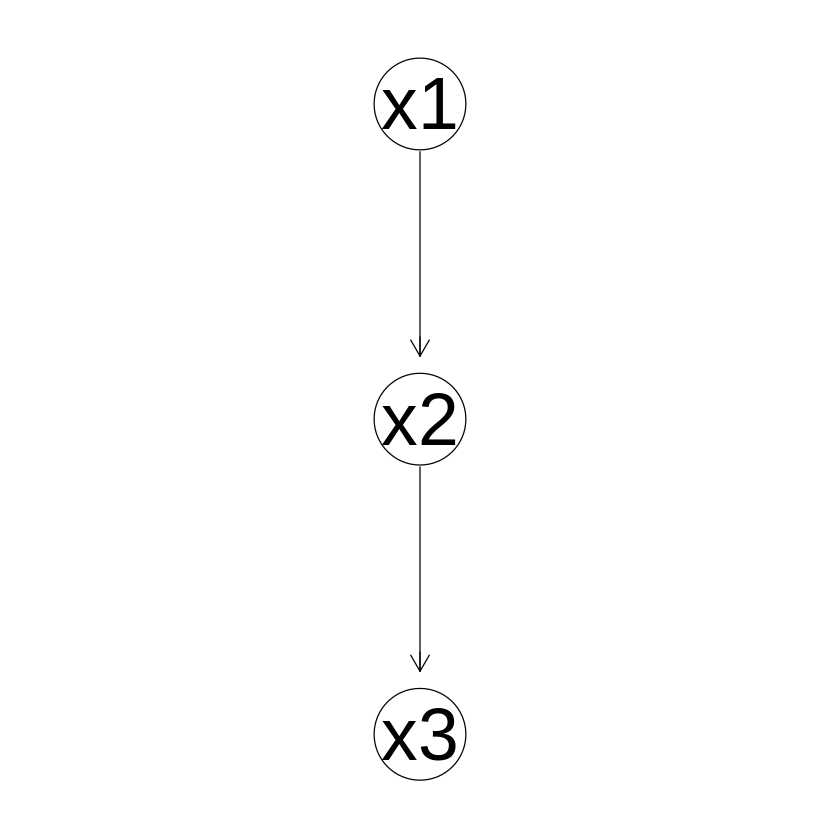

In [12]:
graphviz.plot(b_s)
df_discrete = data.frame(apply(df, c(1,2), as.character), stringsAsFactors=TRUE)
b_p = bn.fit(b_s, data=df_discrete, method='bayes')
print(b_p)

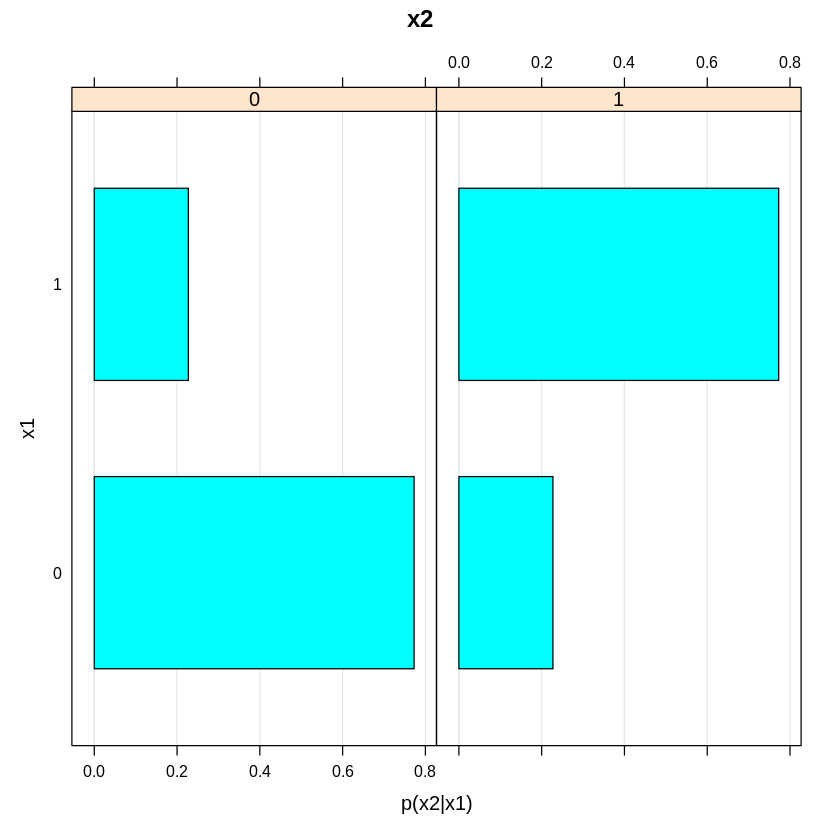

In [14]:
bn.fit.barchart(b_p$x2, main="x2", xlab="p(x2|x1)", ylab="x1")

## Create K2 algo function and compute K2 score

In [66]:
K2 = function(df, u=length(colnames(df))-1, verbose=TRUE, vis=TRUE){
    ###################### K2 algorithm ( df has to be ordered! ) ######################
    # compute all possible instantiations
    inst = lapply(df, n_distinct)
    r    = to_vec(for (i in 1:length(inst)) inst[[i]])
    # define empty dag
    b_s = empty.graph(nodes=colnames(df))
    # K2 score
    k2_score = 0
    # compute parents for each node
    for (i in 1:length(colnames(df))){
        if (verbose) cat("node: ", colnames(df)[i], "\n")
        parents_i = vector()
        p_old = log_f(i, parents_i, r[i], df) # compute equation 20
        if (verbose) cat("\t log p_old: ", p_old, "\n")
        ok_to_proceed = ifelse(i==1, FALSE, TRUE)
        pred_i = seq(1, i-1)
        while (ok_to_proceed && length(parents_i)<u && length(pred_i)-length(parents_i)>0){
            z = best_new_parent(i, parents_i, pred_i, r[i], df)
            if (verbose) cat("\t considering parent: ", colnames(df)[z], "\n")
            p_new = log_f(i, c(parents_i, z), r[i], df)
            if (verbose) cat("\t\t log p_new: ", p_new, "\n")
            if (p_new>p_old){
                p_old = p_new
                parents_i = c(parents_i, z)
                b_s = set.arc(b_s, from=colnames(df)[z], to=colnames(df)[i])
                if (verbose) cat("\t\t accepted \n")
            }else{
                ok_to_proceed = FALSE
                if (verbose) cat("\t\t refused \n")
            }
        }
        k2_score = k2_score + p_old
        if (verbose) cat("\t-> parents: ", colnames(df)[parents_i], "\n")
    }
    if (verbose) cat("K2 score: ", k2_score, "\n")
    if (vis) graphviz.plot(b_s)
    return(b_s)
}

In [ ]:
K2 = function(df, u=length(colnames(df))-1, verbose=TRUE, vis=TRUE){
    ###################### K2 algorithm ( df has to be ordered! ) ######################
    # compute all possible instantiations
    inst = lapply(df, n_distinct)
    r    = to_vec(for (i in 1:length(inst)) inst[[i]])
    # define empty dag
    b_s = empty.graph(nodes=colnames(df))
    # K2 score
    k2_score = 0
    # compute parents for each node
    for (i in 1:length(colnames(df))){
        parents_i = vector()
        p_old = log_f(i, parents_i, r[i], df) # compute equation 20
        ok_to_proceed = ifelse(i==1, FALSE, TRUE) # if i==1, then no parents are possible
        pred_i = seq(1, i-1)
        while (ok_to_proceed && length(parents_i)<u && length(pred_i)-length(parents_i)>0){
            z = best_new_parent(i, parents_i, pred_i, r[i], df)
            p_new = log_f(i, c(parents_i, z), r[i], df)
            if (p_new>p_old){
                p_old = p_new
                parents_i = c(parents_i, z)
                b_s = set.arc(b_s, from=colnames(df)[z], to=colnames(df)[i])
            }else{
                ok_to_proceed = FALSE
            }
        }
        k2_score = k2_score + p_old
    }
    return(b_s)
}

2 2 2 2 2 
node:  x1 
	 log p_old:  -7.927324 
	-> parents:   
node:  x2 
	 log p_old:  -7.927324 
	 considering parent:  x1 
		 log p_new:  -6.802395 
		 accepted 
	-> parents:  x1 
node:  x3 
	 log p_old:  -7.745003 
	 considering parent:  x2 
		 log p_new:  -5.192957 
		 accepted 
	 considering parent:  x1 
		 log p_new:  -5.991465 
		 refused 
	-> parents:  x2 
K2 score:  -19.92268 


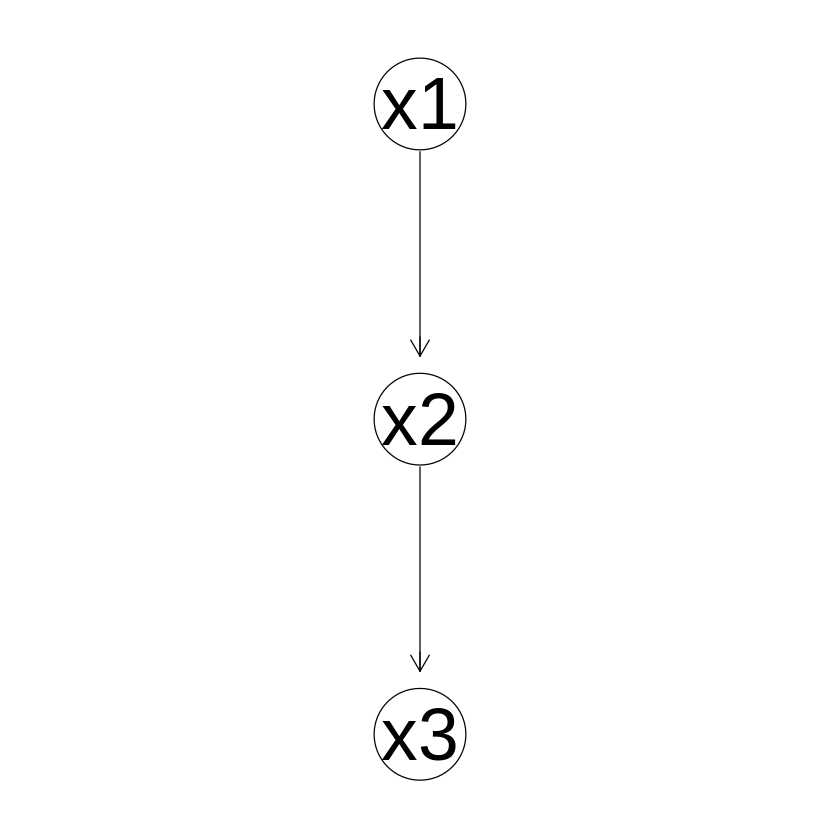

In [71]:
b_s = K2(df)

## Test on earthquake dataset

In [26]:
eq_df = read.csv("./earthquake.csv")

2 2 2 2 2 
node:  Burglary 
	 log p_old:  -55407.01 
	-> parents:   
node:  Earthquake 
	 log p_old:  -97992.58 
	 considering parent:  Burglary 
		 log p_new:  -97998.2 
		 refused 
	-> parents:   
node:  Alarm 
	 log p_old:  -81856.62 
	 considering parent:  Burglary 
		 log p_new:  -42661.52 
		 accepted 
	 considering parent:  Earthquake 
		 log p_new:  -21896.44 
		 accepted 
	-> parents:  Burglary Earthquake 
node:  JohnCalls 
	 log p_old:  -237665 
	 considering parent:  Alarm 
		 log p_new:  -201849.2 
		 accepted 
	 considering parent:  Earthquake 
		 log p_new:  -201854.2 
		 refused 
	-> parents:  Alarm 
node:  MaryCalls 
	 log p_old:  -101706.2 
	 considering parent:  Alarm 
		 log p_new:  -64487.94 
		 accepted 
	 considering parent:  Burglary 
		 log p_new:  -64496.56 
		 refused 
	-> parents:  Alarm 
K2 score:  -441633.1 


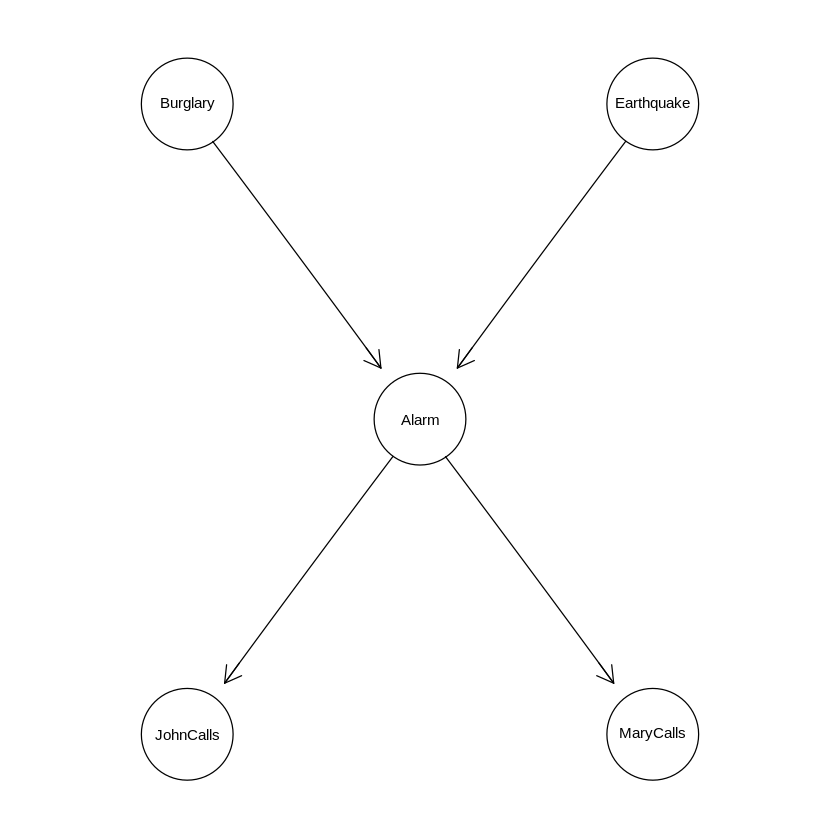

In [72]:
b_s_eq = K2(eq_df)

## Test on child dataset

In [73]:
child_df = read.csv("./child.csv")

In [89]:
child_df = child_df[, c(1, 12, 20, 16, 17, 18, 19, 15, 14, 6, 2, 3, 4, 5, 7, 13, 8, 9, 10, 11)]

2 6 2 3 4 3 3 2 3 2 2 3 3 5 2 2 3 3 2 5 
node:  BirthAsphyxia 
	 log p_old:  -16233.46 
	-> parents:   
node:  Disease 
	 log p_old:  -75586.01 
	 considering parent:  BirthAsphyxia 
		 log p_new:  -74710.24 
		 accepted 
	-> parents:  BirthAsphyxia 
node:  Sick 
	 log p_old:  -31132.5 
	 considering parent:  Disease 
		 log p_new:  -28976.88 
		 accepted 
	 considering parent:  BirthAsphyxia 
		 log p_new:  -28994.2 
		 refused 
	-> parents:  Disease 
node:  DuctFlow 
	 log p_old:  -47477.14 
	 considering parent:  Disease 
		 log p_new:  -24910.92 
		 accepted 
	 considering parent:  BirthAsphyxia 
		 log p_new:  -24955.29 
		 refused 
	-> parents:  Disease 
node:  CardiacMixing 
	 log p_old:  -55934.6 
	 considering parent:  Disease 
		 log p_new:  -29179.36 
		 accepted 
	 considering parent:  BirthAsphyxia 
		 log p_new:  -29240.05 
		 refused 
	-> parents:  Disease 
node:  LungParench 
	 log p_old:  -38686.34 
	 considering parent:  Disease 
		 log p_new:  -32112.95 
		 accepted 

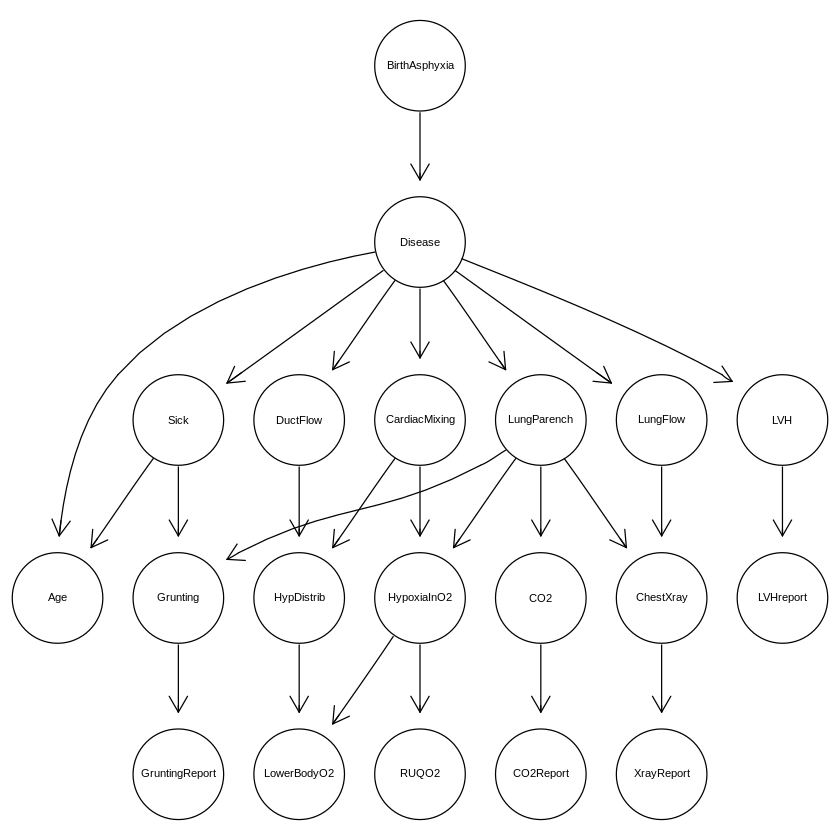

In [91]:
b_s_child = K2(child_df)

## Ordering algorithms

### Mutual Information 

In [5]:
#install.packages('infotheo')
library('infotheo')

In [3]:
MI_data <- function(x_index, y_index, dataset){
    mutinformation(dataset[,x_index], dataset[,y_index])
}

In [6]:
eq_df = read.csv("./earthquake.csv")

In [7]:
eq_df = eq_df[, -1]

In [8]:
# initalize order (choose first variable) 
order_auto <- c(1)
all_nodes <- seq(ncol(eq_df))

# Compute matrix of mutual information
#MI_matrix <- mapply(MI_data, all_nodes, all_nodes, MoreArgs=(list(data)))
MI_matrix <- matrix(rep(0,length(all_nodes)**2), ncol=length(all_nodes))
for(node in all_nodes){
    MI_matrix[node,] <- sapply(all_nodes, MI_data, y_index=node, dataset=eq_df)
}
MI_sum <- matrix(rowSums(MI_matrix),nrow=1)
print(MI_sum)

# For each turn, add to `order` the node with max MI
while (length(order_auto) != ncol(eq_df)) {
    
    # list all the nodes that haven't been ordered
    node_list <- all_nodes[-order_auto]

    # Compute MI values for these nodes and the last one in `order`
    MI_values <- sapply(node_list, MI_data, y_index=tail(order_auto,1), dataset=eq_df)

    # Find which node has the max MI and add it to `order`
    best_node <- node_list[which.max(MI_values)]
    order_auto <- c(order_auto, best_node)
}

# Print order
cat('The final order is: ')
cat(order_auto)

          [,1]      [,2]      [,3]      [,4]      [,5]
[1,] 0.1335085 0.1243115 0.2079881 0.3138768 0.1816933
The final order is: 1 3 5 4 2

### Sorder

In [61]:
# compute mi matrix
mi_mat = mutinformation(eq_df)
# compute max mi for each node
mmi = vector()
for(i in 1:dim(mi_mat)[1]){
    mmi = c(mmi, max(mi_mat[i, -i]))
}
# compute UDN edges
alpha = 0.9
udn_edges = list()
for(i in 1:dim(mi_mat)[1]){
    udn_edges_i = vector()
    for(j in 1:dim(mi_mat)[2]){
        if(i==j) next
        if(mi_mat[i,j]>=alpha*mmi[i] || mi_mat[i,j]>=alpha*mmi[j]){
            udn_edges_i = c(udn_edges_i, j)
        }
    }
    udn_edges = append(udn_edges, list(udn_edges_i))
}
# compute degrees for each node
udn_deg = sapply(udn_edges, length)
udn = data.frame(
    degree = udn_deg,
    node   = colnames(df),
    order  = seq(1, length(udn_deg))
)
# create new order for nodes
udn = udn[order(udn$degree, decreasing=TRUE),]
s_order = udn$order
s_order

[1] 1 2 4 5 3

In [73]:
################### SORDER algorithm ######################
sorder = function(df){
    # compute mi matrix
    mi_mat = mutinformation(df)
    # compute max mi for each node
    mmi = vector()
    for(i in 1:dim(mi_mat)[1]){
        mmi = c(mmi, max(mi_mat[i, -i]))
    }
    # compute UDN edges
    alpha = 0.9
    udn_edges = list()
    for(i in 1:dim(mi_mat)[1]){
        udn_edges_i = vector()
        for(j in 1:dim(mi_mat)[2]){
            if(i==j) next
            if(mi_mat[i,j]>=alpha*mmi[i] || mi_mat[i,j]>=alpha*mmi[j]){
                udn_edges_i = c(udn_edges_i, j)
            }
        }
        udn_edges = append(udn_edges, list(udn_edges_i))
    }
    # compute degrees for each node
    udn_deg = sapply(udn_edges, length)
    udn = data.frame(
        degree = udn_deg,
        node   = colnames(df),
        order  = seq(1, length(udn_deg))
    )
    # create new order for nodes
    udn = udn[order(udn$degree, decreasing=TRUE),]
    s_order = udn$order
    return(s_order)
}

In [74]:
colnames(eq_df)[sorder(eq_df)]

[1] "Alarm"      "Burglary"   "Earthquake" "JohnCalls"  "MaryCalls"

In [65]:
colnames(eq_df)

[1] "Burglary"   "Earthquake" "Alarm"      "JohnCalls"  "MaryCalls"

node:  Alarm 
	 log p_old:  -81856.62 
	-> parents:   
node:  Burglary 
	 log p_old:  -55407.01 
	 considering parent:  Alarm 
		 log p_new:  -16212.38 
		 accepted 
	-> parents:  Alarm 
node:  Earthquake 
	 log p_old:  -97992.58 
	 considering parent:  Alarm 
		 log p_new:  -84102.82 
		 accepted 
	 considering parent:  Burglary 
		 log p_new:  -77233.19 
		 accepted 
	-> parents:  Alarm Burglary 
node:  JohnCalls 
	 log p_old:  -237665 
	 considering parent:  Alarm 
		 log p_new:  -201849.2 
		 accepted 
	 considering parent:  Earthquake 
		 log p_new:  -201854.2 
		 refused 
	-> parents:  Alarm 
node:  MaryCalls 
	 log p_old:  -101706.2 
	 considering parent:  Alarm 
		 log p_new:  -64487.94 
		 accepted 
	 considering parent:  Burglary 
		 log p_new:  -64496.56 
		 refused 
	-> parents:  Alarm 
K2 score:  -441639.3 



  Random/Generated Bayesian network

  model:
   [Alarm][Burglary|Alarm][JohnCalls|Alarm][MaryCalls|Alarm]
   [Earthquake|Alarm:Burglary]
  nodes:                                 5 
  arcs:                                  5 
    undirected arcs:                     0 
    directed arcs:                       5 
  average markov blanket size:           2.00 
  average neighbourhood size:            2.00 
  average branching factor:              1.00 

  generation algorithm:                  Empty 


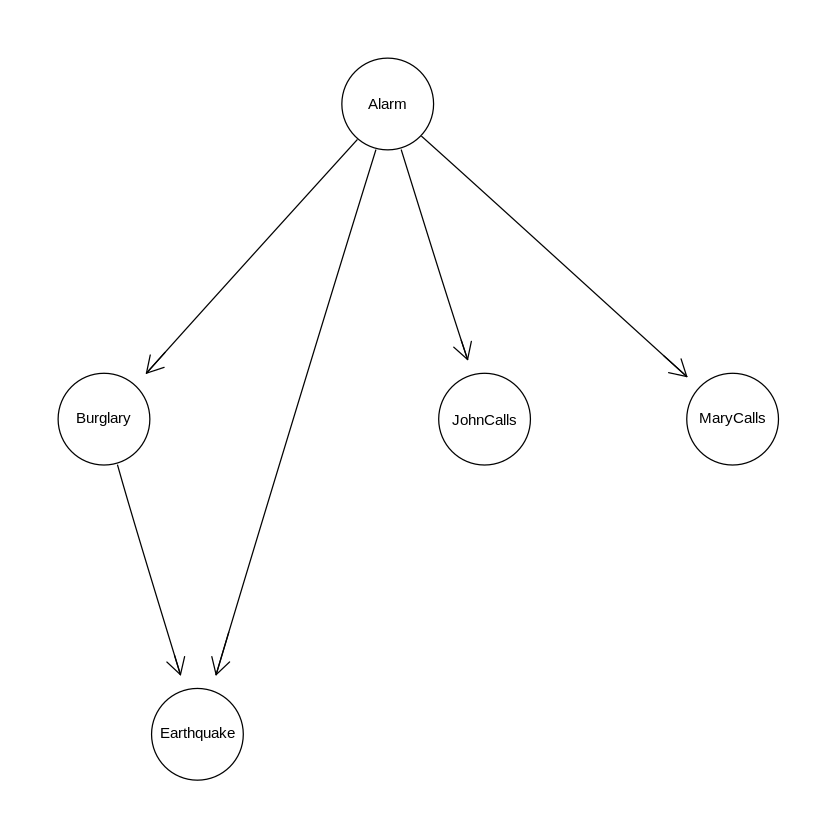

In [75]:
K2(eq_df[, sorder(eq_df)])